# Sentiment Analysis with Logistic Regression

We have a data set of tweets. Let's build a classifier for negative, neutral and positive tweets.

In [1]:
# let's download the dataset
# https://www.kaggle.com/crowdflower/twitter-airline-sentiment
#!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [3]:
df = pd.read_csv('../datasets/tweets/AirlineTweets.csv')

In [4]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


Let's get rid of the columns that we don't need. Seems like we only need airline_sentiment, text, and maybe airline_sentiment_confidence to evaluate our model later on.

In [5]:
df = df[['airline_sentiment', 'airline_sentiment_confidence', 'text']]

In [6]:
df.head()

,airline_sentiment,airline_sentiment_confidence,text
0,neutral,1.0000,@VirginAmerica What @dhepburn said.
1,positive,0.3486,@VirginAmerica plus you've added commercials t...
2,neutral,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,negative,1.0000,@VirginAmerica it's really aggressive to blast...
4,negative,1.0000,@VirginAmerica and it's a really big bad thing...


Let's map the labels so that negative is 0, neutral is 1 and positive is 2

In [7]:
df['airline_sentiment'] = df['airline_sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

In [8]:
df.head()

,airline_sentiment,airline_sentiment_confidence,text
0,1,1.0000,@VirginAmerica What @dhepburn said.
1,2,0.3486,@VirginAmerica plus you've added commercials t...
2,1,0.6837,@VirginAmerica I didn't today... Must mean I n...
3,0,1.0000,@VirginAmerica it's really aggressive to blast...
4,0,1.0000,@VirginAmerica and it's a really big bad thing...


In [9]:
inputs = df['text']
labels = df[['airline_sentiment']]
sample_weigths = df['airline_sentiment_confidence']

array([[<Axes: title={'center': 'airline_sentiment'}>]], dtype=object)

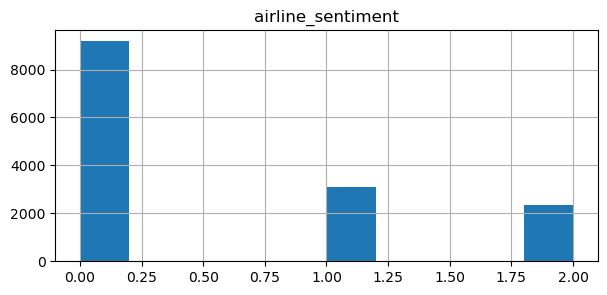

In [10]:
# Let's see if we have imbalanced classes
labels.hist(figsize=(7,3))

We have class imbalance, it seems like there are much more negative tweets than neutral or positive. We'll have to take this into account when evaluating the performance of our model.


Let's split our dataset

In [11]:
inputs_train, inputs_test, Ytrain, Ytest, sample_weigths_train, sample_weigths_test = train_test_split(inputs, labels, sample_weigths, random_state=123, test_size=0.33)

Let's vectorize our inputs

In [12]:
def get_wordnet_pos(treebank_tag):
  if treebank_tag.startswith('J'):
    return wordnet.ADJ
  elif treebank_tag.startswith('V'):
    return wordnet.VERB
  elif treebank_tag.startswith('N'):
    return wordnet.NOUN
  elif treebank_tag.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN
  
class LemmaTokenizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()
  def __call__(self, doc):
    tokens = word_tokenize(doc)
    words_and_tags = nltk.pos_tag(tokens)
    return [self.wnl.lemmatize(word, pos=get_wordnet_pos(tag)) \
            for word, tag in words_and_tags]

In [13]:
vectorizer = CountVectorizer() # start as simple as possible

#vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, tokenizer=LemmaTokenizer())

In [14]:
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test) # do not fit on the test set.

Let's now train our model

In [15]:
model = LogisticRegression(max_iter=5000, random_state=123, class_weight='balanced')
model.fit(Xtrain, Ytrain, sample_weight=sample_weigths_train)

/Users/clement/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=5000, random_state=123)

Now let's compute accuracy, F1-score, AUC and confusion matrixes

train accuracy: 0.9341353996737357
test accuracy: 0.7895281456953642
Training F1-score:  0.9341353996737357
Test F1-score:  0.7895281456953642
Training AUC score:  0.9898149241242556
Test AUC score:  0.908144708219553


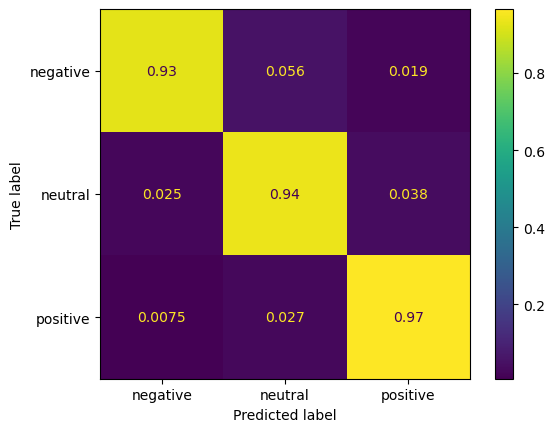

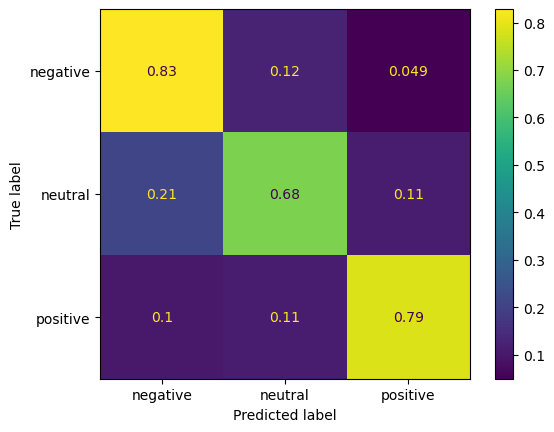

In [16]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

# Proba predictions
Ptrain_proba = model.predict_proba(Xtrain)
Ptest_proba = model.predict_proba(Xtest)

# Accuracy
training_accuracy = model.score(Xtrain, Ytrain)
test_accuracy = model.score(Xtest, Ytest)

# F1-score
training_f1_score = f1_score(Ytrain, Ptrain, average='micro')
test_f1_score = f1_score(Ytest, Ptest, average='micro')

# AUC
training_auc = roc_auc_score(Ytrain, Ptrain_proba, multi_class='ovr')
test_auc = roc_auc_score(Ytest, Ptest_proba, multi_class='ovr')

print("train accuracy:", training_accuracy)
print("test accuracy:", test_accuracy)
print("Training F1-score: ", training_f1_score)
print("Test F1-score: ", test_f1_score)
print("Training AUC score: ", training_auc)
print("Test AUC score: ", test_auc)

cm_train = confusion_matrix(Ytrain, Ptrain, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['negative', 'neutral', 'positive'])
disp_train.plot()

cm_test = confusion_matrix(Ytest, Ptest, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['negative', 'neutral', 'positive'])
disp_test.plot()

## Do it again but with binary labels and models: Positive and negative

In [17]:
df_b = df[df['airline_sentiment'].isin([0,2])] # 0 is negative, 2 is positive
df_b['airline_sentiment'] = df_b['airline_sentiment'].map({0: 0, 2: 1}) # now 0 is negative and 1 is positive

/var/folders/cv/rf4bgk9d1sqgbjbk5ydbt4740000gn/T/ipykernel_24557/4023428520.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b['airline_sentiment'] = df_b['airline_sentiment'].map({0: 0, 2: 1}) # now 0 is negative and 1 is positive


In [18]:
df_b.head()

,airline_sentiment,airline_sentiment_confidence,text
1,1,0.3486,@VirginAmerica plus you've added commercials t...
3,0,1.0000,@VirginAmerica it's really aggressive to blast...
4,0,1.0000,@VirginAmerica and it's a really big bad thing...
5,0,1.0000,@VirginAmerica seriously would pay $30 a fligh...
6,1,0.6745,"@VirginAmerica yes, nearly every time I fly VX..."


In [25]:
inputs = df_b['text']
labels = df_b[['airline_sentiment']]
sample_weigths = df_b['airline_sentiment_confidence']

inputs_train, inputs_test, Ytrain, Ytest, sample_weigths_train, sample_weigths_test = train_test_split(inputs, labels, sample_weigths, random_state=123, test_size=0.2)

In [26]:
Xtrain = vectorizer.fit_transform(inputs_train)
Xtest = vectorizer.transform(inputs_test) # do not fit on the test set.

model = LogisticRegression(max_iter=5000, random_state=123, class_weight='balanced')
model.fit(Xtrain, Ytrain, sample_weight=sample_weigths_train)

/Users/clement/anaconda3/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight='balanced', max_iter=5000, random_state=123)

train accuracy: 0.9729202772963604
test accuracy: 0.92031182330013
Training F1-score:  0.9362570117287098
Test F1-score:  0.8220502901353963
Training AUC score:  0.9965524880237033
Test AUC score:  0.9606826170667515


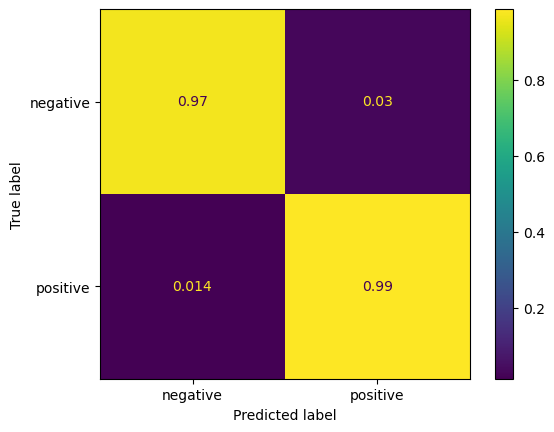

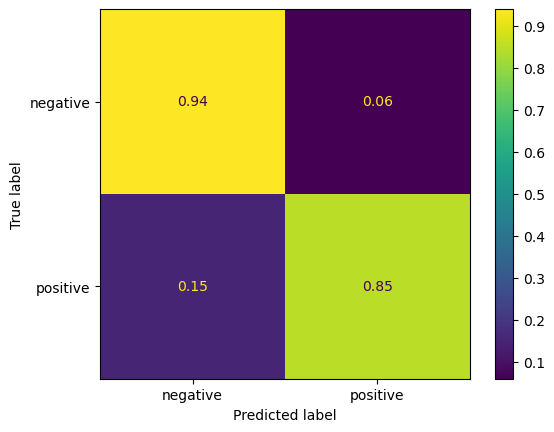

In [27]:
Ptrain = model.predict(Xtrain)
Ptest = model.predict(Xtest)

# Proba predictions
Ptrain_proba = model.predict_proba(Xtrain)
Ptest_proba = model.predict_proba(Xtest)

# Accuracy
training_accuracy = model.score(Xtrain, Ytrain)
test_accuracy = model.score(Xtest, Ytest)

# F1-score
training_f1_score = f1_score(Ytrain, Ptrain)
test_f1_score = f1_score(Ytest, Ptest)

# AUC
training_auc = roc_auc_score(Ytrain, Ptrain_proba[:,1])
test_auc = roc_auc_score(Ytest, Ptest_proba[:,1])

print("train accuracy:", training_accuracy)
print("test accuracy:", test_accuracy)
print("Training F1-score: ", training_f1_score)
print("Test F1-score: ", test_f1_score)
print("Training AUC score: ", training_auc)
print("Test AUC score: ", test_auc)

cm_train = confusion_matrix(Ytrain, Ptrain, normalize='true')
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['negative', 'positive'])
disp_train.plot()

cm_test = confusion_matrix(Ytest, Ptest, normalize='true')
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['negative', 'positive'])
disp_test.plot()

Let's get the weights from the model

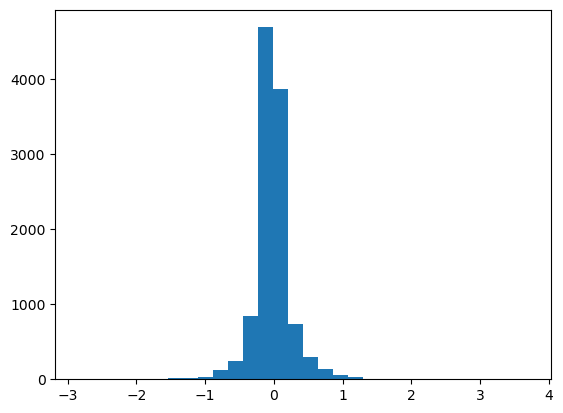

In [30]:
W = model.coef_
word_index_map = vectorizer.vocabulary_

plt.hist(W[0], bins=30);

In [34]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 1.5

print("Most positive words:")
for word, index in word_index_map.items():
    weight = W[0][index]
    if weight > threshold:
        print(word, weight)
print('\n\n')
print("Most negative words:")
for word, index in word_index_map.items():
    weight = model.coef_[0][index]
    if weight < -threshold:
        print(word, weight)



Most positive words:
impressed 2.10577587932197
thanks 3.037576969878674
great 2.5572890159047375
good 1.7227928699925137
exceptional 1.679712881969509
best 2.1476463007362288
thank 3.7060235370535457
awesome 2.747901608795997
love 2.5187160287108474
amazing 2.2763044482058636
worries 3.00817428188637
excellent 1.991739572386697
kudos 2.3809564333189854
appreciate 1.9526003686756117
thx 1.9060962759791915
thankful 1.954622500338257
nc 1.549344946661589
wonderful 2.1723775606153697
sweet 1.5469122148399133



Most negative words:
not -1.5219394507368735
nothing -2.449478292709376
delay -1.644073415924131
hold -2.1851368425281312
delayed -1.8058337800549606
hours -1.8830643530796154
worst -2.851121076378717
rude -1.9575069558795009
website -1.6372859453245758
terrible -1.5535750410854359
until -1.515534246813063
doesn -1.5500575389515356
money -1.5574680084817092
disappointed -1.628641702939051
